In [2]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
import pandas as pd
df = pd.read_csv("/content/breast-cancer.csv")

In [5]:
# Import necessary modules for data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For feature scaling
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets

# X contains the features (all columns except the 'diagnosis' and the "id" column)
X = df.drop(["diagnosis","id"], axis=1)
# y contains the labels (only the 'diagnosis' column)
y = df["diagnosis"]

# Split the dataset into training and testing sets
# random_state=0 ensures reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Initialize StandardScaler for feature scaling
scalar = StandardScaler()

# Fit the StandardScaler to the training data
scalar.fit(X_train)

# Transform the training and testing data using the fitted StandardScaler
# This scales each feature to have a mean of 0 and a standard deviation of 1
X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)

y_train = y_train.reset_index().drop("index", axis = 1).diagnosis.values
y_test = y_test.reset_index().drop("index", axis = 1).diagnosis.values


y_train[y_train == "M"] = 1
y_train[y_train == "B"] = 0

y_test[y_test == "M"] = 1
y_test[y_test == "B"] = 0

one_hot = OneHotEncoder()
y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

In [ ]:
y_train

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,

In [ ]:
[i.index(1) for i in y_train_hot]

AttributeError: 'matrix' object has no attribute 'index'

## Helper functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mlrose
import time
from sklearn.metrics import f1_score

def nn_model_args(hidden_nodes=[20 for i in range(5)], activation='relu', \
                                 algorithm='random_hill_climb', max_iters=10000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=False, clip_max=5, max_attempts=1, \
                                 curve=True):
    args = {"hidden_nodes": hidden_nodes,
            "activation": activation,
            "bias": bias,
            "is_classifier": is_classifier,
            "learning_rate": learning_rate,
            "early_stopping": early_stopping,
            "clip_max": clip_max,
            "max_attempts": max_attempts,
            "curve": curve,
            "algorithm": algorithm}

    if algorithm == "genetic_alg":
        args["mutation_prob"] = 0.1
        args["pop_size"] = 200
    elif algorithm == 'simulated_annealing':
        args["schedule"] = mlrose.GeomDecay()
    return args

def grid_search(args, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot):
    times = []
    train_scores = []
    test_scores = []
    iters_range = range(50, 1000, 50)

    for iters in iters_range:
        times_iters = []
        train_score_iters = []
        test_score_iters = []

        for r in range(1, 102, 10):
            args["max_iters"] = iters
            args["random_state"] = r
            nn_model = mlrose.NeuralNetwork(**args)  # Unpack the dictionary

            start = time.time()
            nn_model.fit(X_train_scaled, y_train_hot)
            end = time.time()
            times_iters.append(end - start)

            # Predict labels for train set and assess accuracy
            y_train_pred = nn_model.predict(X_train_scaled)
            y_train_f1 = f1_score(np.asarray(y_train_hot), np.asarray(y_train_pred), average='weighted')

            # Predict labels for test set and assess accuracy
            y_test_pred = nn_model.predict(X_test_scaled)
            y_test_f1 = f1_score(np.asarray(y_test_hot), np.asarray(y_test_pred), average='weighted')

            train_score_iters.append(y_train_f1)
            test_score_iters.append(y_test_f1)

        times.append(times_iters)
        train_scores.append(train_score_iters)
        test_scores.append(test_score_iters)

    # Calculate average time, train scores, and test scores across runs for each iteration
    avg_time = np.mean(times, axis=1)
    avg_train_scores = np.mean(train_scores, axis=1)
    avg_test_scores = np.mean(test_scores, axis=1)

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Plot Average Time vs Iterations
    axes[0].plot(iters_range, avg_time, marker='o', linestyle='-')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Average Time (s)')
    axes[0].set_title('Average Time vs Iterations')

    # Plot Average Train Scores vs Iterations
    axes[1].plot(iters_range, avg_train_scores, marker='o', linestyle='-')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Average Train Scores')
    axes[1].set_title('Average Train Scores vs Iterations')

    # Plot Average Test Scores vs Iterations
    axes[2].plot(iters_range, avg_test_scores, marker='o', linestyle='-')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Average Test Scores')
    axes[2].set_title('Average Test Scores vs Iterations')

    plt.tight_layout()
    plt.show()

    return avg_time, avg_train_scores, avg_test_scores


In [ ]:
def grid_search(args, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot):
    times = []
    train_scores = []
    test_scores = []
    iters_range = list(range(50, 1000, 50)) + [2000, 5000, 10000]

    for iters in iters_range:
        times_iters = []
        train_score_iters = []
        test_score_iters = []

        for r in range(1, 102, 10):
            args["max_iters"] = iters
            args["random_state"] = r
            nn_model = mlrose.NeuralNetwork(**args)  # Unpack the dictionary

            start = time.time()
            nn_model.fit(X_train_scaled, y_train_hot)
            end = time.time()
            times_iters.append(end - start)

            # Predict labels for train set and assess accuracy
            y_train_pred = nn_model.predict(X_train_scaled)
            y_train_f1 = f1_score(np.asarray(y_train_hot), np.asarray(y_train_pred), average='weighted')

            # Predict labels for test set and assess accuracy
            y_test_pred = nn_model.predict(X_test_scaled)
            y_test_f1 = f1_score(np.asarray(y_test_hot), np.asarray(y_test_pred), average='weighted')

            train_score_iters.append(y_train_f1)
            test_score_iters.append(y_test_f1)

        times.append(times_iters)
        train_scores.append(train_score_iters)
        test_scores.append(test_score_iters)

    # Calculate average time, train scores, and test scores across runs for each iteration
    avg_time = np.mean(times, axis=1)
    avg_train_scores = np.mean(train_scores, axis=1)
    avg_test_scores = np.mean(test_scores, axis=1)

    # Calculate standard errors of mean for each metric
    sem_time = np.std(times, axis=1) / np.sqrt(len(range(1, 102, 10)))
    sem_train_scores = np.std(train_scores, axis=1) / np.sqrt(len(range(1, 102, 10)))
    sem_test_scores = np.std(test_scores, axis=1) / np.sqrt(len(range(1, 102, 10)))

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Plot Average Time vs Iterations with Standard Errors
    axes[0].fill_between(np.log(iters_range), avg_time - sem_time, avg_time + sem_time, alpha=0.2)
    axes[0].plot(np.log(iters_range), avg_time, marker='o', linestyle='-')
    axes[0].set_xlabel('log(Iterations)')
    axes[0].set_ylabel('Average Time (s)')
    axes[0].set_title('Average Time vs Iterations')

    # Plot Average Train Scores vs Iterations with Standard Errors
    axes[1].fill_between(np.log(iters_range), avg_train_scores - sem_train_scores, avg_train_scores + sem_train_scores, alpha=0.2)
    axes[1].plot(np.log(iters_range), avg_train_scores, marker='o', linestyle='-')
    axes[1].set_xlabel('log(Iterations)')
    axes[1].set_ylabel('Average Train Scores')
    axes[1].set_title('Average Train Scores vs Iterations')

    # Plot Average Test Scores vs Iterations with Standard Errors
    axes[2].fill_between(np.log(iters_range), avg_test_scores - sem_test_scores, avg_test_scores + sem_test_scores, alpha=0.2)
    axes[2].plot(np.log(iters_range), avg_test_scores, marker='o', linestyle='-')
    axes[2].set_xlabel('log(Iterations)')
    axes[2].set_ylabel('Average Test Scores')
    axes[2].set_title('Average Test Scores vs Iterations')

    plt.tight_layout()
    plt.show()

    return avg_time, avg_train_scores, avg_test_scores

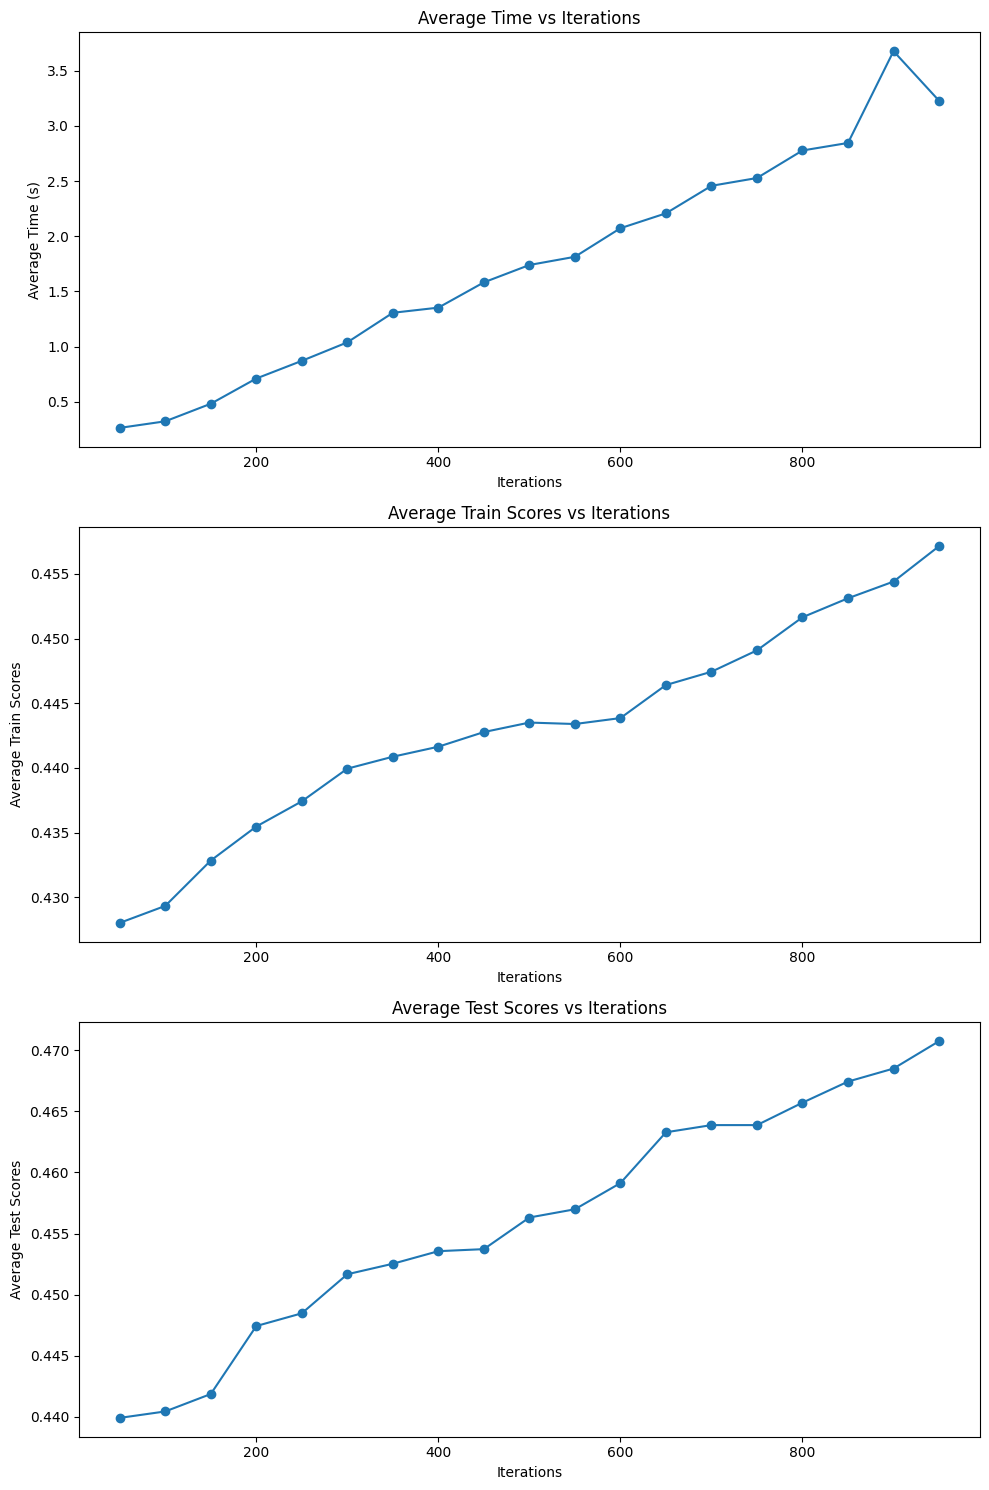

(array([0.26430124, 0.32388271, 0.48296729, 0.71145983, 0.87149939,
        1.03903636, 1.3068531 , 1.35339043, 1.58239549, 1.7396871 ,
        1.81393307, 2.0727585 , 2.20763961, 2.45685311, 2.52747711,
        2.7768725 , 2.84506169, 3.67635415, 3.22759329]),
 array([0.42802865, 0.42934199, 0.43284656, 0.43547566, 0.43742351,
        0.43994774, 0.44087041, 0.44164447, 0.44277612, 0.44351049,
        0.44339761, 0.44385699, 0.44641047, 0.44743842, 0.44909132,
        0.45164865, 0.45311576, 0.454406  , 0.45714234]),
 array([0.43991942, 0.44044641, 0.44187267, 0.4474359 , 0.44847648,
        0.45167412, 0.45253274, 0.45356179, 0.45372834, 0.45631688,
        0.45699041, 0.45913372, 0.46329053, 0.46387837, 0.46387837,
        0.46571313, 0.46743976, 0.46850593, 0.47074646]))

In [ ]:
args = nn_model_args()
grid_search(args, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot)

### Randomized hill climbing

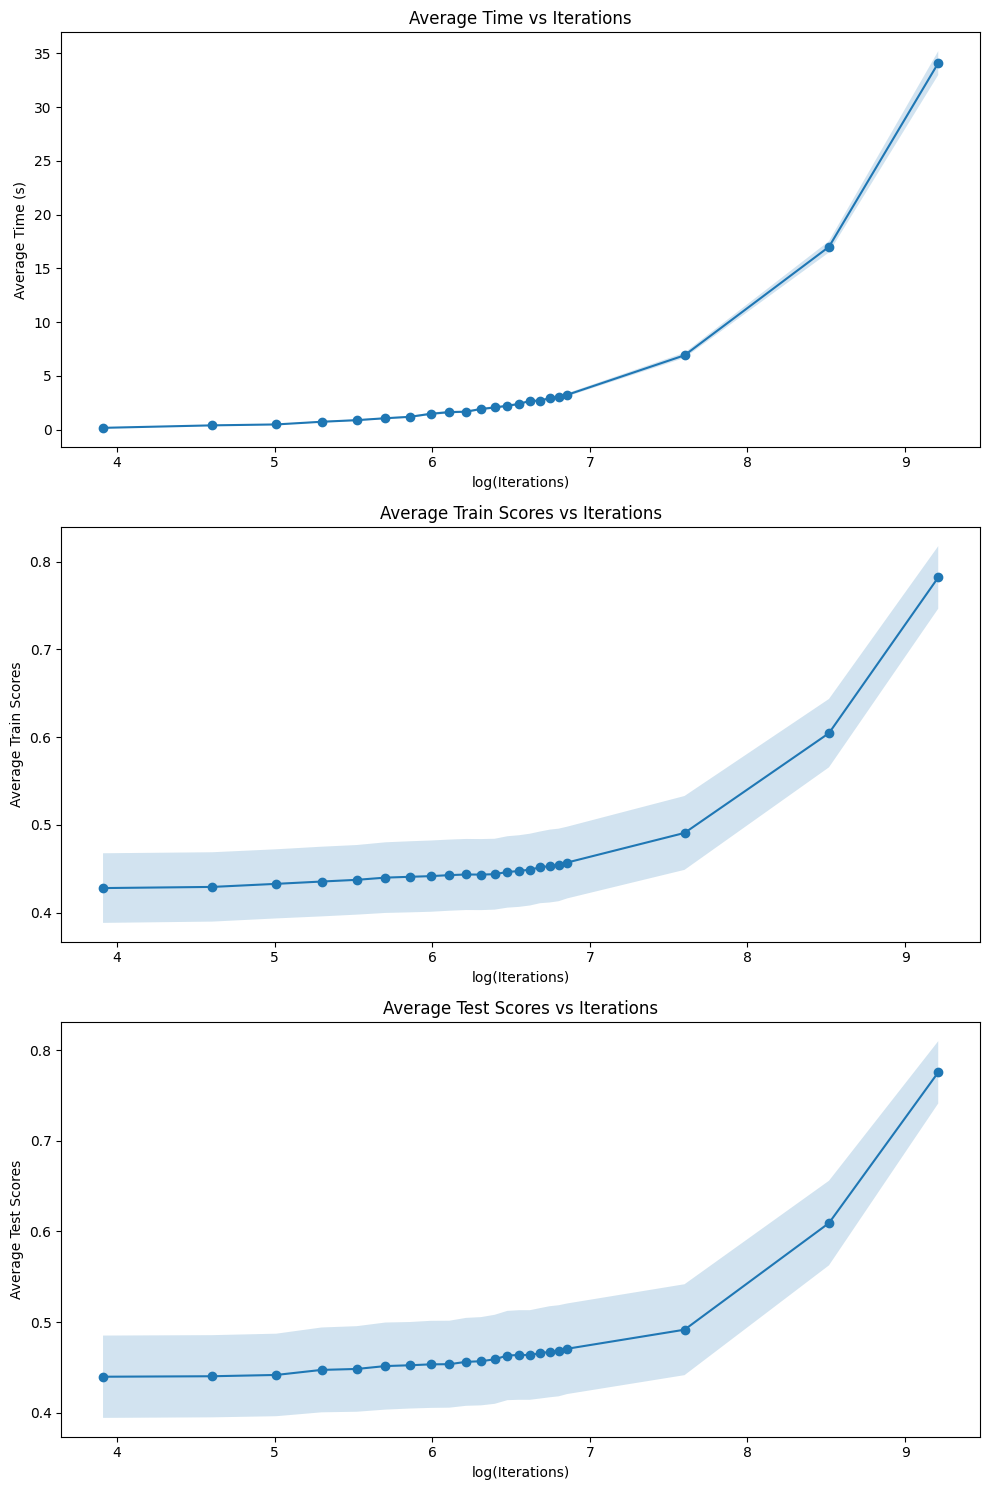

(array([ 0.16390911,  0.39526994,  0.48059971,  0.72849484,  0.87856425,
         1.05844821,  1.18762136,  1.47080801,  1.62499259,  1.66450594,
         1.91947657,  2.05901792,  2.21776052,  2.38258958,  2.67889344,
         2.68501804,  2.93423406,  3.05478597,  3.23578234,  6.91020161,
        17.00033171, 34.08780661]),
 array([0.42802865, 0.42934199, 0.43284656, 0.43547566, 0.43742351,
        0.43994774, 0.44087041, 0.44164447, 0.44277612, 0.44351049,
        0.44339761, 0.44385699, 0.44641047, 0.44743842, 0.44909132,
        0.45164865, 0.45311576, 0.454406  , 0.45714234, 0.49088867,
        0.60462398, 0.78212832]),
 array([0.43991942, 0.44044641, 0.44187267, 0.4474359 , 0.44847648,
        0.45167412, 0.45253274, 0.45356179, 0.45372834, 0.45631688,
        0.45699041, 0.45913372, 0.46329053, 0.46387837, 0.46387837,
        0.46571313, 0.46743976, 0.46850593, 0.47074646, 0.49175223,
        0.60929288, 0.77544589]))

In [ ]:
args = nn_model_args()
grid_search(args, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot)

### Genetic Algorithm

In [ ]:
args = nn_model_args(algorithm = 'genetic_alg')
grid_search(args, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot)

### Simulated annealing

In [ ]:
args = nn_model_args(algorithm = 'simulated_annealing')
grid_search(args, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot)

### Plotting all together

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.10/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr

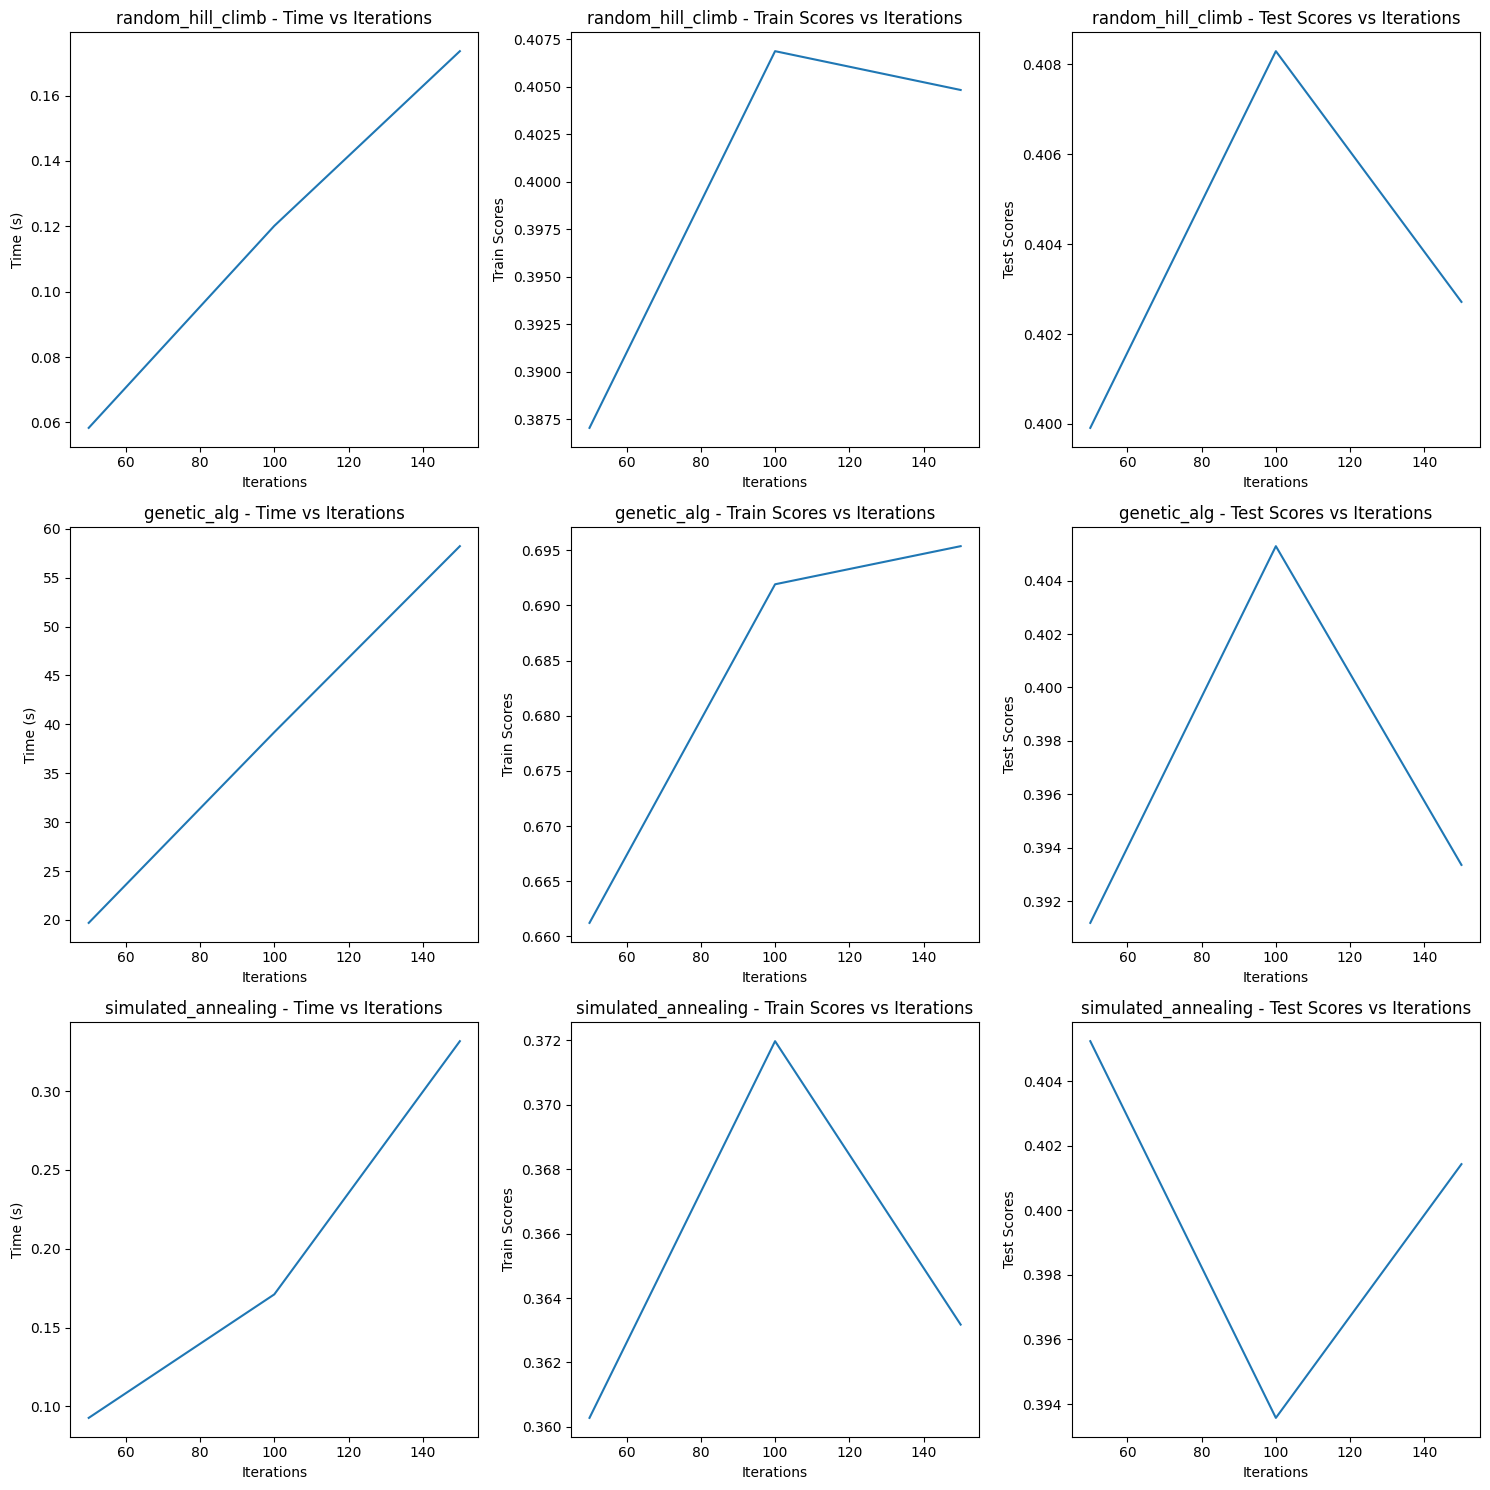

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mlrose
import time
from sklearn.metrics import f1_score
iters_range = list(range(50, 200, 50))
r_range = range(1, 22, 10)



def nn_model_args(hidden_nodes=[20 for i in range(5)], activation='relu', \
                                 algorithm='random_hill_climb', max_iters=10000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=False, clip_max=5, max_attempts=1, \
                                 curve=True):
    args = {"hidden_nodes": hidden_nodes,
            "activation": activation,
            "bias": bias,
            "is_classifier": is_classifier,
            "learning_rate": learning_rate,
            "early_stopping": early_stopping,
            "clip_max": clip_max,
            "max_attempts": max_attempts,
            "curve": curve,
            "algorithm": algorithm}

    if algorithm == "genetic_alg":
        args["mutation_prob"] = 0.1
        args["pop_size"] = 200
    elif algorithm == 'simulated_annealing':
        args["schedule"] = mlrose.GeomDecay()
    return args

def grid_search(args_list, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot):
    results = {}

    for args in args_list:
        times = []
        train_scores = []
        test_scores = []
        for iters in iters_range:
            times_iters = []
            train_score_iters = []
            test_score_iters = []
            for r in r_range:
                args["max_iters"] = iters
                args["random_state"] = r
                nn_model = mlrose.NeuralNetwork(**args)  # Unpack the dictionary

                start = time.time()
                nn_model.fit(X_train_scaled, y_train_hot)
                end = time.time()
                times_iters.append(end - start)

                # Predict labels for train set and assess accuracy
                y_train_pred = nn_model.predict(X_train_scaled)
                y_train_f1 = f1_score(np.asarray(y_train_hot), np.asarray(y_train_pred))

                # Predict labels for test set and assess accuracy
                y_test_pred = nn_model.predict(X_test_scaled)
                y_test_f1 = f1_score(np.asarray(y_test_hot), np.asarray(y_test_pred), average='weighted')

                train_score_iters.append(y_train_f1)
                test_score_iters.append(y_test_f1)

            times.append(times_iters)
            train_scores.append(train_score_iters)
            test_scores.append(test_score_iters)

        avg_time = np.mean(times, axis=1)
        avg_train_scores = np.mean(train_scores, axis=1)
        avg_test_scores = np.mean(test_scores, axis=1)

        results[args["algorithm"]] = {"time": avg_time, "train_scores": avg_train_scores, "test_scores": avg_test_scores}

    return results

def plot_error_grid(results):
    fig, axes = plt.subplots(len(results), 3, figsize=(15, 5*len(results)))

    for i, (optimizer, data) in enumerate(results.items()):
        axes[i, 0].plot(iters_range, data["time"], label='Time')
        axes[i, 0].set_title(f'{optimizer} - Time vs Iterations')
        axes[i, 0].set_xlabel('Iterations')
        axes[i, 0].set_ylabel('Time (s)')

        axes[i, 1].plot(iters_range, data["train_scores"], label='Train Scores')
        axes[i, 1].set_title(f'{optimizer} - Train Scores vs Iterations')
        axes[i, 1].set_xlabel('Iterations')
        axes[i, 1].set_ylabel('Train Scores')

        axes[i, 2].plot(iters_range, data["test_scores"], label='Test Scores')
        axes[i, 2].set_title(f'{optimizer} - Test Scores vs Iterations')
        axes[i, 2].set_xlabel('Iterations')
        axes[i, 2].set_ylabel('Test Scores')

    plt.tight_layout()
    plt.show()


# Example usage:

# Define the arguments for each optimizer
args_list = [
    nn_model_args(algorithm='random_hill_climb'),
    nn_model_args(algorithm='genetic_alg'),
    nn_model_args(algorithm='simulated_annealing')
]

# Dummy data
X_train_scaled = np.random.rand(100, 10)
y_train_hot = np.random.randint(0, 2, 100)
X_test_scaled = np.random.rand(50, 10)
y_test_hot = np.random.randint(0, 2, 50)

# Perform grid search
results = grid_search(args_list, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot)

# Plot error grid
plot_error_grid(results)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import mlrose
import time
from sklearn.metrics import f1_score
iters_range = range(50, 500, 50)
r_range = range(1, 45, 10)

def nn_model_args(hidden_nodes=[20 for i in range(5)], activation='relu', \
                                 algorithm='random_hill_climb', max_iters=10000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=False, clip_max=5, max_attempts=1, \
                                 curve=True):
    args = {"hidden_nodes": hidden_nodes,
            "activation": activation,
            "bias": bias,
            "is_classifier": is_classifier,
            "learning_rate": learning_rate,
            "early_stopping": early_stopping,
            "clip_max": clip_max,
            "max_attempts": max_attempts,
            "curve": curve,
            "algorithm": algorithm}

    if algorithm == "genetic_alg":
        args["mutation_prob"] = 0.1
        args["pop_size"] = 200
    elif algorithm == 'simulated_annealing':
        args["schedule"] = mlrose.GeomDecay()
    return args

def grid_search(args_list, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot):
    results = {}

    for args in args_list:
        times = []
        train_scores = []
        test_scores = []
        for iters in iters_range:
            times_iters = []
            train_score_iters = []
            test_score_iters = []
            for r in r_range:
                args["max_iters"] = iters
                args["random_state"] = r
                nn_model = mlrose.NeuralNetwork(**args)  # Unpack the dictionary

                start = time.time()
                nn_model.fit(X_train_scaled, y_train_hot)
                end = time.time()
                times_iters.append(end - start)

                # Predict labels for train set and assess accuracy
                y_train_pred = nn_model.predict(X_train_scaled)
                y_train_f1 = f1_score(np.asarray(y_train_hot), np.asarray(y_train_pred), average='weighted')

                # Predict labels for test set and assess accuracy
                y_test_pred = nn_model.predict(X_test_scaled)
                y_test_f1 = f1_score(np.asarray(y_test_hot), np.asarray(y_test_pred), average='weighted')

                train_score_iters.append(y_train_f1)
                test_score_iters.append(y_test_f1)

            times.append(times_iters)
            train_scores.append(train_score_iters)
            test_scores.append(test_score_iters)

        avg_time = np.mean(times, axis=1)
        avg_train_scores = np.mean(train_scores, axis=1)
        avg_test_scores = np.mean(test_scores, axis=1)
        sem_time = np.std(times, axis=1) / np.sqrt(len(r_range))
        sem_train_scores = np.std(train_scores, axis=1) / np.sqrt(len(r_range))
        sem_test_scores = np.std(test_scores, axis=1) / np.sqrt(len(r_range))

        results[args["algorithm"]] = {"time": avg_time, "sem_time": sem_time,
                                       "train_scores": avg_train_scores, "sem_train_scores": sem_train_scores,
                                       "test_scores": avg_test_scores, "sem_test_scores": sem_test_scores}

    return results

def plot_error_grid(results):
    fig, axes = plt.subplots(len(results), 3, figsize=(15, 5*len(results)))

    for i, (optimizer, data) in enumerate(results.items()):
        # Plot Time vs Iterations with SEM
        axes[i, 0].errorbar(iters_range, data["time"], yerr=data["sem_time"], fmt='-o')
        axes[i, 0].set_title(f'{optimizer} - Time vs Iterations')
        axes[i, 0].set_xlabel('Iterations')
        axes[i, 0].set_ylabel('Time (s)')

        # Plot Train Scores vs Iterations with SEM
        axes[i, 1].errorbar(iters_range, data["train_scores"], yerr=data["sem_train_scores"], fmt='-o')
        axes[i, 1].set_title(f'{optimizer} - Train Scores vs Iterations')
        axes[i, 1].set_xlabel('Iterations')
        axes[i, 1].set_ylabel('Train Scores')

        # Plot Test Scores vs Iterations with SEM
        axes[i, 2].errorbar(iters_range, data["test_scores"], yerr=data["sem_test_scores"], fmt='-o')
        axes[i, 2].set_title(f'{optimizer} - Test Scores vs Iterations')
        axes[i, 2].set_xlabel


In [ ]:
# Example usage:

# Define the arguments for each optimizer
args_list = [
    nn_model_args(algorithm='random_hill_climb'),
    nn_model_args(algorithm='genetic_alg'),
    nn_model_args(algorithm='simulated_annealing')
]

# Perform grid search
results = grid_search(args_list, X_train_scaled, y_train_hot, X_test_scaled, y_test_hot)

# Plot error grid
plot_error_grid(results)

In [ ]:
def plot_error_grid(results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    for i, (optimizer, data) in enumerate(results.items()):
        # Plot Time vs Iterations with SEM
        axes[0].plot(iters_range, data["time"], label=f'{optimizer} - Time', linestyle='-', marker='o')

        # Plot Train Scores vs Iterations with SEM
        axes[1].plot(iters_range, data["train_scores"], label=f'{optimizer} - Train Scores', linestyle='-', marker='o')

        # Plot Test Scores vs Iterations with SEM
        axes[2].plot(iters_range, data["test_scores"], label=f'{optimizer} - Test Scores', linestyle='-', marker='o')

    axes[0].set_title('Time vs Iterations')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Time')
    axes[0].legend()

    axes[1].set_title('Train Scores vs Iterations')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Train Scores')
    axes[1].legend()

    axes[2].set_title('Test Scores vs Iterations')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Test Scores')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


## Randomized hill climbing

In [ ]:
# Initialize neural network object and fit object
nn_model_rhc = mlrose.NeuralNetwork(hidden_nodes = [20 for i in range(5)], activation = 'relu', \
                                 algorithm = 'random_hill_climb', max_iters = 10000, \
                                 bias = True, is_classifier = True, learning_rate = 0.01, \
                                 early_stopping = True, clip_max = 5, max_attempts = 1000, \
                                 random_state = 3, curve = True)

nn_model_rhc.fit(X_train_scaled, y_train_hot)

NeuralNetwork(clip_max=5, early_stopping=True,
              hidden_nodes=[20, 20, 20, 20, 20], learning_rate=0.01,
              max_iters=10000)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Predict labels for train set and assess accuracy
y_train_pred = nn_model_rhc.predict(X_train_scaled)

y_train_accuracy = accuracy_score(np.asarray(y_train_hot), np.asarray(y_train_pred))

print(y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = nn_model_rhc.predict(X_test_scaled)

y_test_accuracy = accuracy_score(np.asarray(y_test_hot), np.asarray(y_test_pred))
y_test_f1 = f1_score(np.asarray(y_test_hot), np.asarray(y_test_pred), average = 'weighted')

print(y_test_accuracy, y_test_f1)

0.6384976525821596


TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html